In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_sigma_e

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from ising_model import SimulateMH

from scipy import signal

In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [3]:
TTc = 2/np.log(1+np.sqrt(2))

In [4]:
pool = Pool(32)

In [5]:
with open("dumps/heat-capac-4-44-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)
NtoT[2] = 2.51

In [5]:
with open("dumps/heat-capac-freebc-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)

In [16]:
Ns = [2]
n = Ns[0]
eps = 0.004
while n < 100:
    if abs(NtoT[n] - NtoT[Ns[-1]]) > eps:
        Ns.append(n)
    n+=1

44


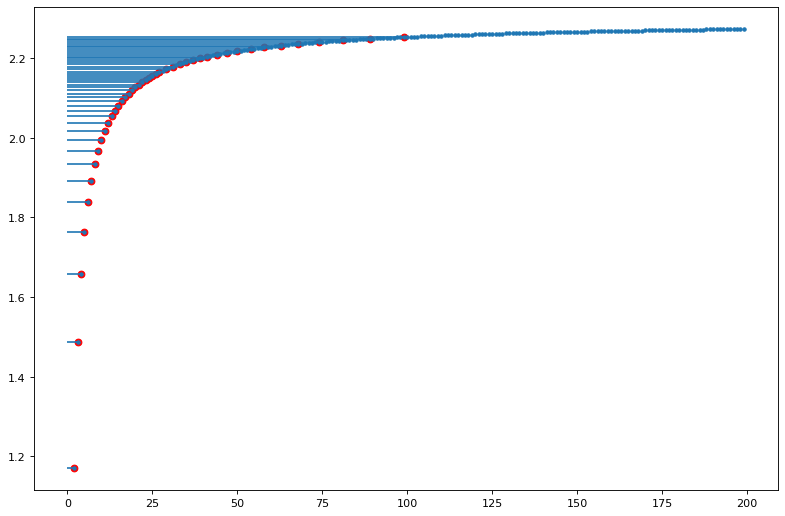

In [17]:
plt.plot(list(NtoT.keys()), list(NtoT.values()), ".")

for n in Ns:
    plt.scatter(n, NtoT[n], c="r")
    plt.hlines(y = NtoT[n], xmin=0, xmax=n)
print(len(Ns))

In [8]:
34*10/512/60*2048

22.666666666666668

In [18]:
results = []
for N in Ns:
    TcN = NtoT[N]
    Ts = np.linspace(TcN-0.1, TcN+0.1, 4096)
#     Ts = np.linspace(0.5, 3.5, 10*32*3)
    for Ts1 in tqdm(Ts.reshape(32, -1)):
        runs = len(Ts1)
        res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
                zip(*(Ts1,
                      [N]*runs, # N
                      [4*10**7]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                      [SimulateMH.BoundaryCondition.NotPoriodic]*runs

                          )),
    #             chunksize=1
            )
        results+= res

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
len(results)/4096

44.0

In [21]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

In [22]:
gb = df.groupby("N")

In [23]:
def find_peak(vals, l=5, r=30):
    pids = []
    for w in range(l,r):
        smooth =  np.convolve(vals, np.ones(w), mode="same")/w
        pids.append(np.argmax(smooth))
    return int(np.median(pids))

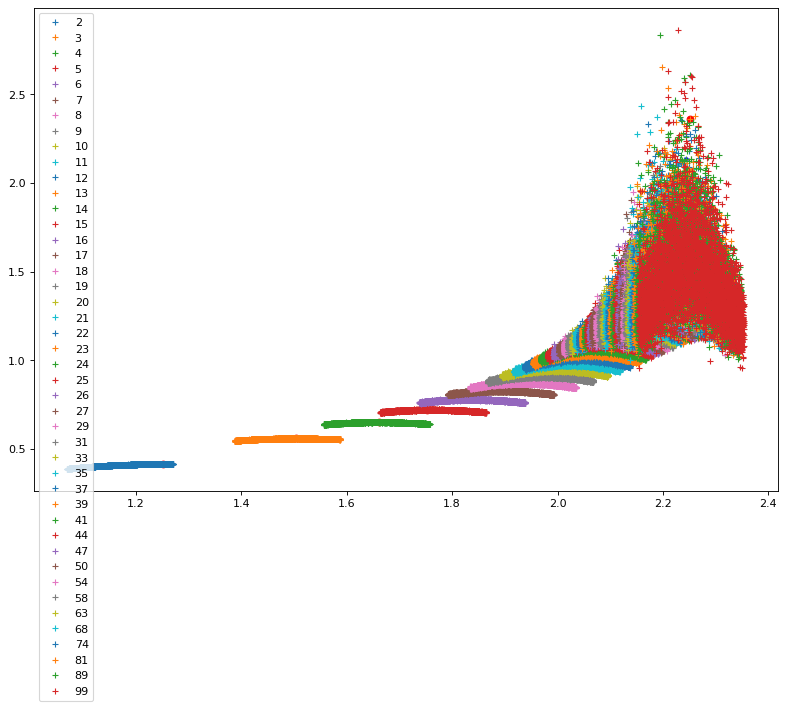

In [38]:
Ns = []
Tcs1 = []
Tcs2 = []
Tcs3 = []
Tcs3_err = []

for N in gb.groups:
    Ns.append(N)
    
    df4 = gb.get_group(N)
    plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")
    
    pid = find_peak(df4.C, l=5, r=30)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
    
    Tcs1.append(df4.temp.iloc[pid])
    
    pid = find_peak(df4.C, l=10, r=60)
    plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=10)
    
    Tcs2.append(df4.temp.iloc[pid])
    
    def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
    try:
        popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=3000, 
                                  p0=[TTc-0.1, 1.5, 1])
        Tcs3.append(popt[0])
        Tcs3_err.append(popt_cov[0,0]**0.5)
        
    except Exception as e:
        Tcs3.append(np.nan)
        Tcs3_err.append(np.nan)
        print(N, e)
    
plt.legend()

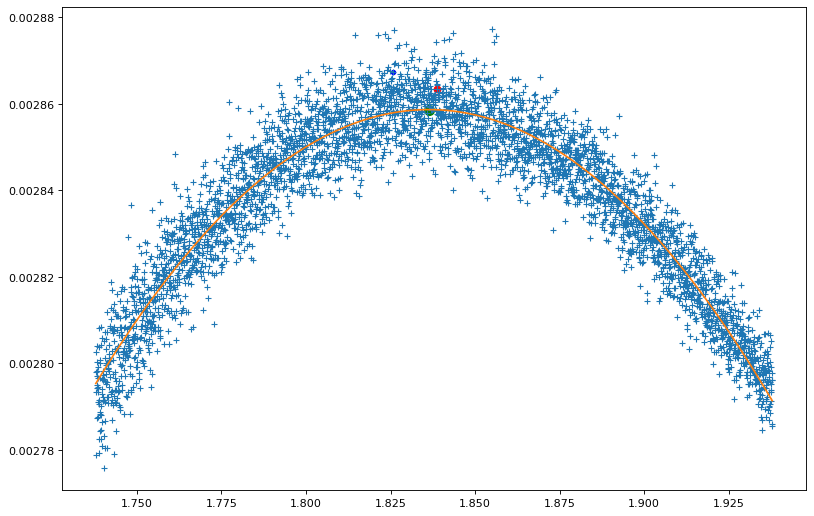

In [39]:
df4 = gb.get_group(6)
plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")

def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=3000, 
                                  p0=[TTc, 1.5, 1])
plt.plot(df4.temp, f(df4.temp, *popt))
plt.scatter(popt[0], f(popt[0], *popt), c="g", s=80)

pid = find_peak(df4.C, l=5, r=30)
plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
pid = find_peak(df4.C, l=10, r=60)
plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=15)
# plt.xlim(2,2.5)
# plt.xlim(1,1.5)

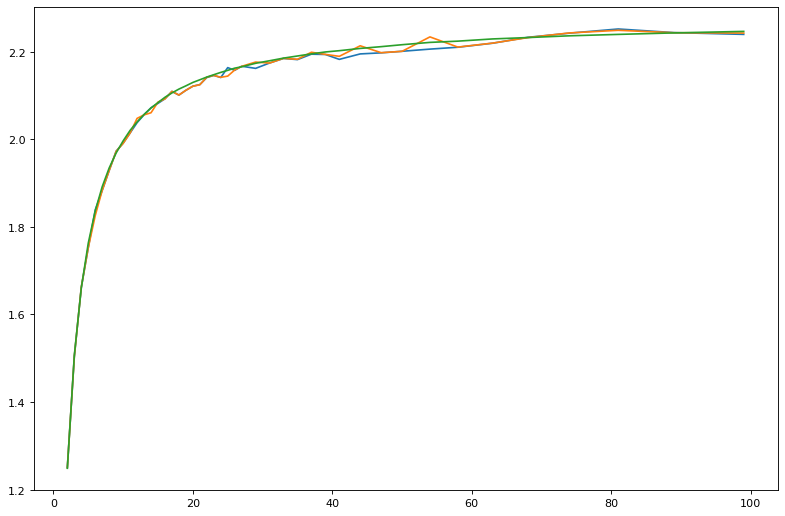

In [40]:
plt.plot(Ns, Tcs1)
plt.plot(Ns, Tcs2)
plt.plot(Ns, Tcs3)

In [41]:
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))
popt1, popt1_cov = curve_fit(f, Ns[2:], Tcs1[2:])
popt2, popt2_cov = curve_fit(f, Ns, Tcs2)
popt3, popt3_cov = curve_fit(f, Ns, Tcs3, sigma=np.array(Tcs3_err))

In [42]:
Tc, a, mu = popt1
print(f"T={Tc:0.3f} a={a:0.3f} mu={mu:0.3f}")
Tc_err, a_err, mu_err = np.sqrt(popt1_cov.diagonal())
print(f"T={Tc_err:0.6f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.285 a=-2.039 mu=1.182
T=0.005022 a=0.057044 mu=0.028396


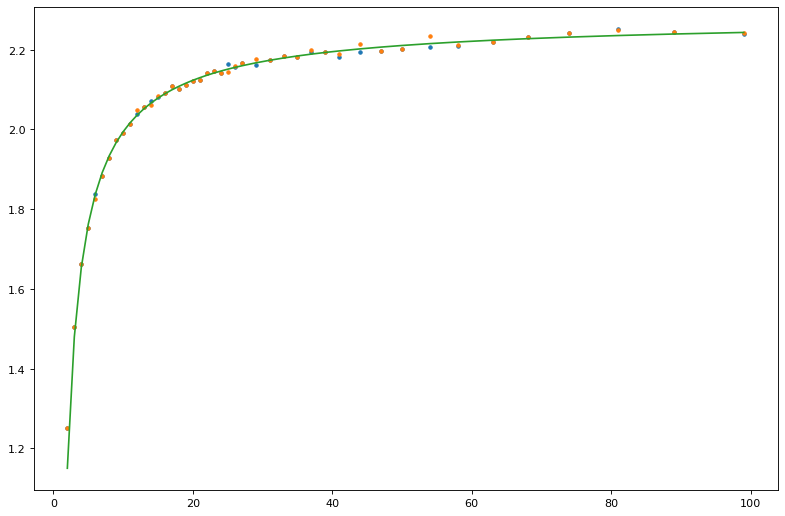

In [43]:
# plt.plot(Ns, Tcs1, "+")
# plt.plot(Ns, Tcs2, "+")
plt.plot(Ns, Tcs1, ".")
plt.plot(Ns, Tcs2, ".")

plt.plot(Ns, f(np.array(Ns), *popt1))
# plt.plot(Ns, f(np.array(Ns), *popt1))

In [53]:
l,r=10,-15
popt3, popt3_cov = curve_fit(f, Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a, mu = popt3
print(f"T={Tc:0.4f} a={a:0.3f} mu={mu:0.3f}    Tc = {TTc:0.5f}")
Tc_err, a_err, mu_err = np.sqrt(popt2_cov.diagonal())
print(f"T={Tc_err:0.4f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.2801 a=-2.343 mu=1.092    Tc = 2.26919
T=0.0055 a=0.021061 mu=0.023316


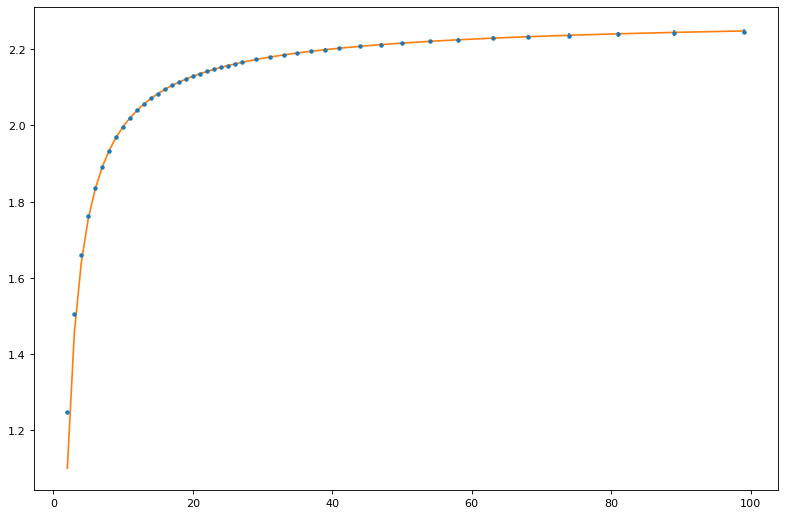

In [46]:
# plt.plot(Ns, Tcs1, "+")
# plt.plot(Ns, Tcs2, "+")
plt.errorbar(Ns, Tcs3, yerr=np.array(Tcs3_err)*10, fmt=".")
# plt.plot(Ns, f(np.array(Ns), *popt1))
plt.plot(Ns, f(np.array(Ns), *popt3))

# single

In [5]:
results = []
Ts = np.linspace(0.5, 3.5,10*64)
for Ts1 in tqdm(Ts.reshape(10, 64)):
    runs = len(Ts1)
    res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
              zip(*(Ts1,
                      [6]*runs, # N
                      [4*10**7]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                      [SimulateMH.BoundaryCondition.NotPoriodic]*runs
                          )),
    #             chunksize=1
            )
    results+= res

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
len(results)

640

In [15]:
with open("heat-capac-6N-4e7-10000.pkl", "rb") as f:
    results = pickle.load(f)

In [16]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

In [13]:
df_free = pd.DataFrame(results_free, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df_free["C"] = df_free.std_E**2/df_free.temp**2

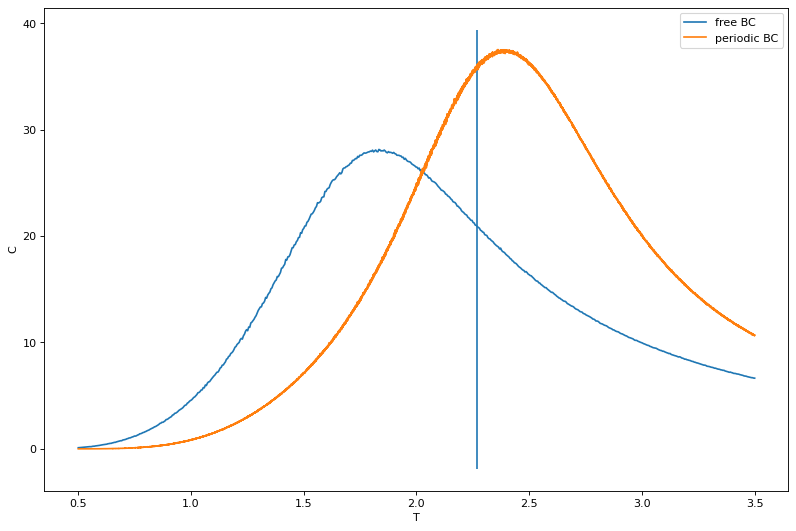

In [18]:
plt.plot(df_free.temp, df_free.C, label="free BC")
plt.plot(df.temp, df.C, label="periodic BC")

plt.vlines(x=TTc, ymin=plt.ylim()[0], ymax=plt.ylim()[1])
plt.xlabel("T")
plt.ylabel("C")
plt.legend()
